# Wolkenobjekte analog zum HACI-Ansatz

Eine gute Möglichkeit wirklich nur isolierte wolkenobjekte zu bekommen, könnte sein sie ähnlich wie mit dem HACI-Ansatz abzuleiten.

Die Vorgehensweise wäre folgende:

1. Segmentierung des IR-10,8-µm-Kanals und des HRV-Kanals mit einem Schwellwertverfahren oder der NWCSAF-Wolkenmaske
2. Anwendung eines Pufferradius
3. Überprüfung, welche neuen Objekte mit einer bestimmten Mindestlebensdauer im nächsten Zeitschritt entstehen
4. Überprüfen, welche von diesen Objekten mit einem HACI-Objekt verbunden sind

In [4]:
import numpy as np
import xarray as xr
import pandas as pd

import sys
sys.path.append("/vols/talos/home/stephan/utils")
sys.path.append("/vols/talos/home/stephan/utils/tracking/")
import object_tracking as ot

import haci as hci
import load_satellite_data as lsd
import datetime as dt

import MSGtools as mst

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage as ndi
from skimage.morphology import selem, dilation
from scipy.signal import fftconvolve

import nwcsaf_ct_cmap
ct_cmap,ct_norm,ct_names = nwcsaf_ct_cmap.nwcsaf_ct_cmap()

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
pixel_sizes = xr.open_dataset("/vols/talos/home/stephan/data/SEVIRI/auxdata/msg_rss_eu_pixel_sizes.nc")

In [11]:
mean_row_dist = pixel_sizes.mean_row_distance[103:245,352:624] 
mean_col_dist = pixel_sizes.mean_col_distance[103:245,352:624]

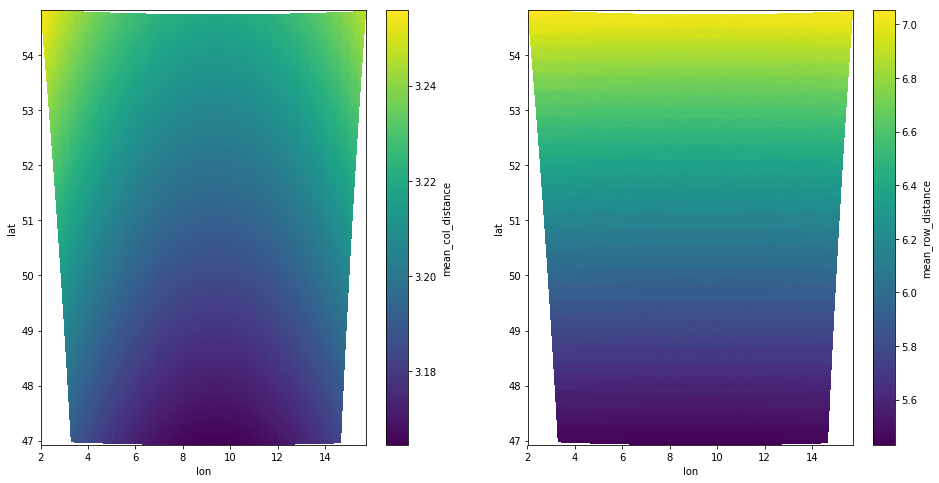

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
mean_col_dist.plot(x='lon',y='lat',ax=ax[0])
mean_row_dist.plot(x='lon',y='lat',ax=ax[1])

In [18]:
print mean_col_dist.mean()
print mean_row_dist.mean()

<xarray.DataArray 'mean_col_distance' ()>
array(3.199141)
<xarray.DataArray 'mean_row_distance' ()>
array(6.130496)


Als erstes suchen wir uns mal ein Beispieldatum aus. Da wir auch HRV-Daten verwenden wollen, wählen wir nur den Zeitraum, in dem der Sonnezenitwinkel kleiner als 80° innerhalb der Radolandomäne ist (vorher ermittelt).

In [5]:
dates = pd.date_range(start='20130618t0505',end='20130618t1750',freq='5min')

In [77]:
ir_data = [lsd.load_satellite_data(d.to_pydatetime(),channel='IR_108',region='eu')[103:245,352:624] 
            for d in dates]

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

In [58]:
ct = [mst.get_nwcsaf_prod('CT',day=d.to_pydatetime(),calibrate=True)[103:245,352:624] for d in dates]

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colourbar(mappable,**kwargs):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax, **kwargs)

[Text(1,0,'not proc.'),
 Text(1,0,'land'),
 Text(1,0,'sea'),
 Text(1,0,'land snow'),
 Text(1,0,'sea ice'),
 Text(1,0,'v. low cf.'),
 Text(1,0,'v. low sf.'),
 Text(1,0,'low cf.'),
 Text(1,0,'low sf.'),
 Text(1,0,'med. cf.'),
 Text(1,0,'med. sf.'),
 Text(1,0,'high cf.'),
 Text(1,0,'high sf.'),
 Text(1,0,'v. high cf.'),
 Text(1,0,'v. high sf.'),
 Text(1,0,'sem. thin'),
 Text(1,0,'sem. med.'),
 Text(1,0,'sem. thick'),
 Text(1,0,'sem. above'),
 Text(1,0,'broken')]

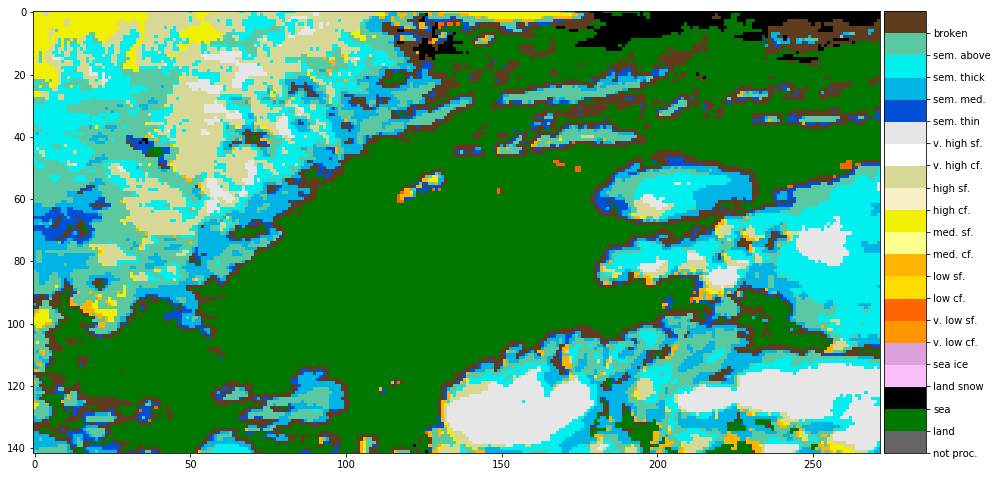

In [82]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ct_plot = ax.imshow(ct[144],cmap=ct_cmap,norm=ct_norm,vmin=0,vmax=20)
cbar = colourbar(ct_plot,ticks=np.arange(0,20))
cbar.ax.set_yticklabels(ct_names)

In [21]:
hrv_data = [lsd.load_satellite_data(d.to_pydatetime(),channel='HRV',region='eu')[309:735,1056:1872] 
            for d in dates]

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

Als nächstes suchen wir uns nur die bewölkten Bereiche heraus und maskieren alle semitransparenten Wolken, weil die Probleme machen können.

In [83]:
ir_masked = []

for i, m in enumerate(ct):
    ir = np.ma.masked_where(m<6,ir_data[i])
    ir = np.ma.masked_where(ct[i]>=15,ir)
    
    ir_masked.append(~ir.mask)

In [84]:
hrv_masked = []

for i, h in enumerate(hrv_data):
    hrv = np.ma.masked_less(h,0.2)
    
    hrv_masked.append(~hrv.mask)

NameError: name 'hrv_data' is not defined

In [85]:
ir_masked = np.array(ir_masked)
hrv_masked = np.array(hrv_masked)

In [86]:
del(ir_data,hrv_data,ct)

NameError: name 'hrv_data' is not defined

In [87]:
import gc
gc.collect()

10108

Text(0.5,1,u'IR 10,8 \xb5m, maskiert, 2013-06-18 13:25:00')

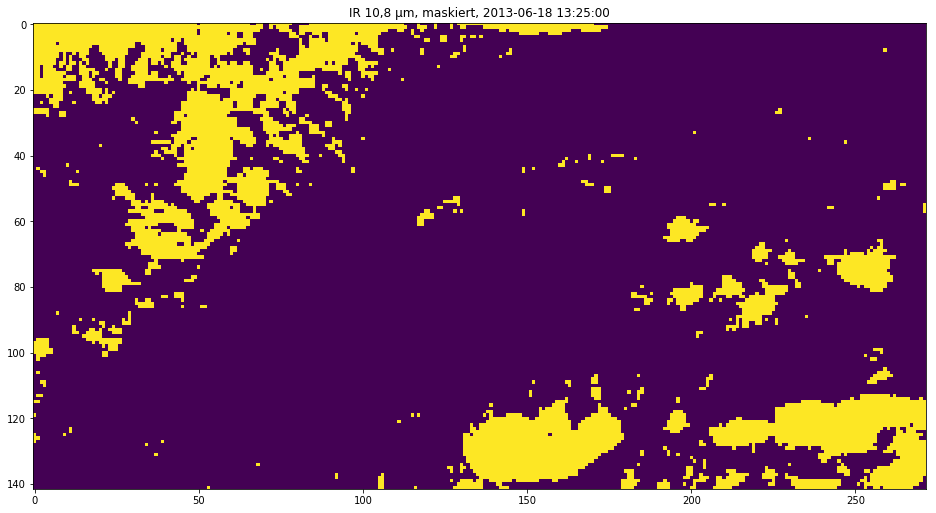

In [89]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(ir_masked[144])
ax.set_title(u"IR 10,8 µm, maskiert, {}".format(dates[100]))

Als nächstes markieren wir die maskieren Daten.

In [90]:
sel =np.zeros((3,3,3))
sel[1,:,:] = 1
objmap, nr_obj = hci.label_objects(ir_masked,sel)

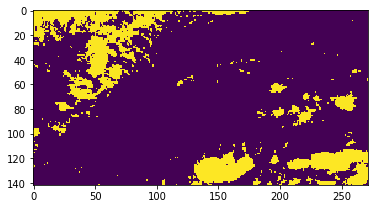

In [91]:
plt.imshow(objmap[144])

Als nächstes puffern wir die segmentierten Daten mit einem Pufferradius von 15 km.

In [92]:
sel= selem.rectangle(5,3)

In [93]:
buf_mask = np.ones_like(ir_masked,dtype="uint8")

In [94]:
for i in np.arange(np.array(ir_masked.shape[0])):
    buf_mask[i,2:-2,1:-1] = fftconvolve(ir_masked[i,:,:],sel,mode='valid')>0.1

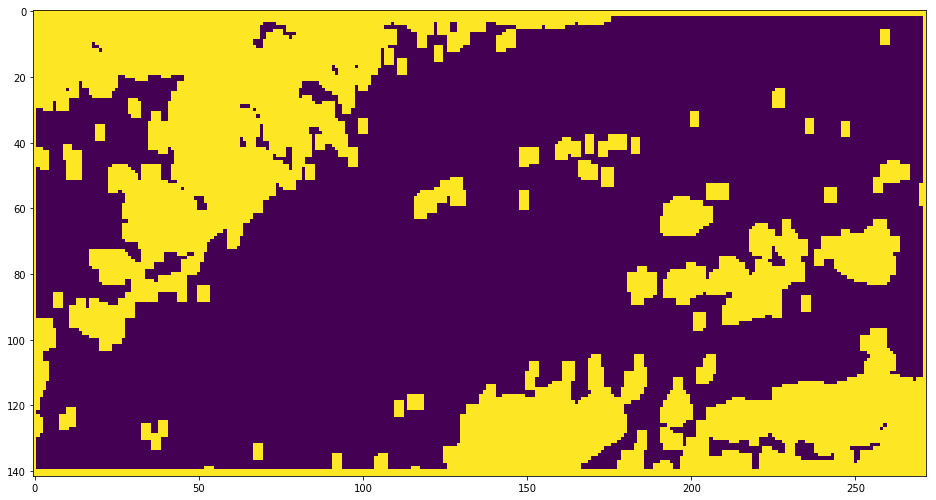

In [95]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(buf_mask[144])

In [96]:
ci_mask = hci.ci_mask(ir_masked,buf_mask)

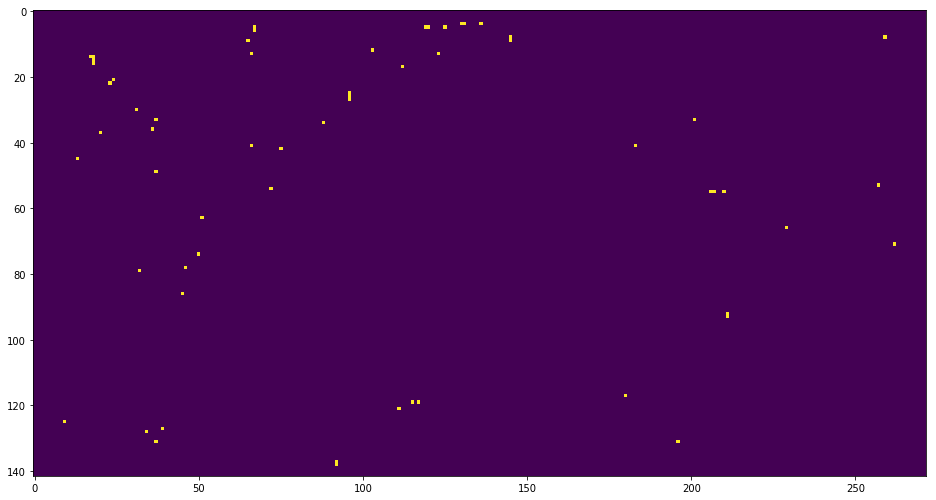

In [97]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(ci_mask[144])

In [98]:
ci_labels = objmap[ci_mask]

In [99]:
ci_labels

array([  352,   354,   360, ..., 25250, 25252, 25253], dtype=int32)

In [100]:
objmap = hci.link_objects(objmap,ci_labels,6)[0]

0
1
2
3
4
5


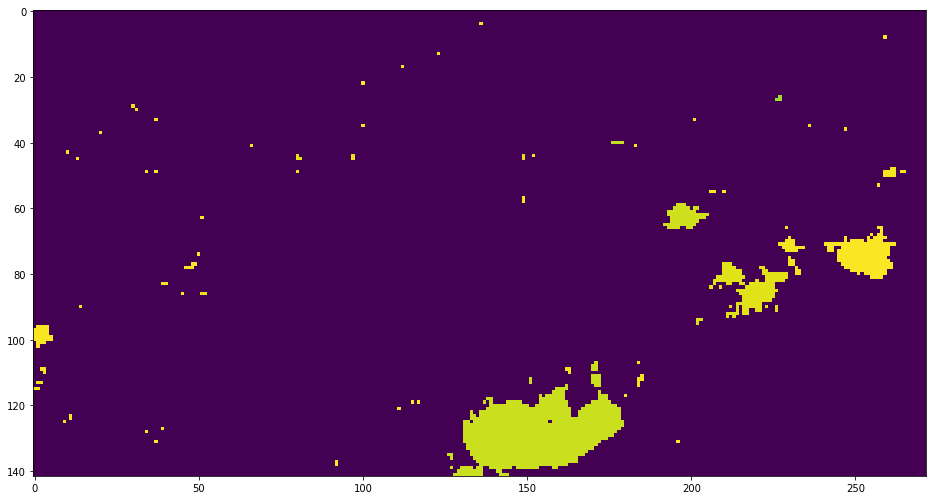

In [106]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(objmap[144])

In [156]:
test = ot.generate_graph_from_components(objmap,dates)

In [155]:
reload(ot)

<module 'object_tracking' from '/vols/talos/home/stephan/utils/tracking/object_tracking.py'>

In [157]:
test

(<networkx.classes.graph.Graph at 0x7f71be6b5f50>,
  <networkx.classes.graph.Graph at 0x7f71be004a50>])

In [138]:
a = []
for i in xrange(len(test[2][0])):
    d_r = mean_row_dist[test[2][0][i],test[2][1][i]].data
    d_c = mean_col_dist[test[2][0][i],test[2][1][i]].data
    
    a.append(d_r*d_c)

In [140]:
np.sum(np.array(a))

63.92546338157263

In [142]:
(6.1*3.2)*3

58.56

In [158]:
ot.sort_graph_by_timesteps(test[1][1])

{74: ['2013-06-18 11:15:00_1358'],
 75: ['2013-06-18 11:20:00_1358'],
 76: ['2013-06-18 11:25:00_1358'],
 77: ['2013-06-18 11:30:00_1358'],
 78: ['2013-06-18 11:35:00_1358'],
 79: ['2013-06-18 11:40:00_1358'],
 80: ['2013-06-18 11:45:00_1358']}

In [ ]:
import sys
sys.path.append("/")

In [275]:
objprops = hci.object_props(dates,objmap,ci_mask)

In [276]:
objprops

,time,id,flags,t0,t1,l00,l01,c00,c01,l0,l1,c0,c1
2013-06-18-000001,2013-06-18 00:05:00,1,0,1,288,2,140,1,271,0,142,0,272
2013-06-18-000002,2013-06-18 00:05:00,2,0,1,8,2,4,117,122,0,4,112,142
2013-06-18-000003,2013-06-18 00:05:00,3,0,1,6,32,34,213,219,32,34,209,219
2013-06-18-000004,2013-06-18 00:05:00,4,0,1,2,41,42,129,130,41,42,129,130
2013-06-18-000005,2013-06-18 00:05:00,5,0,1,2,66,67,89,90,66,67,89,90
2013-06-18-000006,2013-06-18 00:05:00,6,0,1,9,65,69,187,192,65,69,184,197
2013-06-18-000007,2013-06-18 00:05:00,7,0,1,19,71,82,210,238,69,84,205,239
2013-06-18-000008,2013-06-18 00:05:00,8,0,1,2,79,80,90,91,79,80,90,91
2013-06-18-000009,2013-06-18 00:05:00,9,0,1,2,81,82,90,91,81,82,90,91
2013-06-18-000010,2013-06-18 00:05:00,10,0,1,8,95,96,199,200,94,99,194,206


In [ ]:
contours = []

In [ ]:
for i, obj in 